In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT

# Constants

In [2]:
#CONSTANTSSSSSS

#generator constants
circuit_depth = 3
circuit_width = 3

# Data prep

In [3]:
df = pd.read_csv("bezdekIris.data", header=None)
#give classes numbers
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
#reduce to just 2 classes
df = df[df[4] != 2]

In [4]:
train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()
label0 = -1
n_data_points = 2

n_label0s = n_data_points / 2
n_label1s = n_data_points / 2

label0s = []
label1s = []

for i in range(len(labels)):
    if labels[i] == 0 and n_label0s > 0:
        n_label0s -= 1
        label0s.append(i)
        
    if labels[i] == 1 and n_label1s > 0:
        n_label1s -= 1
        label1s.append(i)
        
    if n_label0s < 1 and n_label1s < 1:
        break

idx = label0s + label1s
        
data = data[idx]
labels = labels[idx]

# Helper functions

In [5]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

In [6]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [7]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
    return circuit.to_gate(label="destructive_swap")

def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [8]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
#     print(circuit)
    return circuit.to_gate(label="swap")
# swap(2)

In [9]:
def seriessum(n):
    n_sum = 0
    for i in range(n):
        n_sum += i
    return n_sum

# Oracle meuk

In [10]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

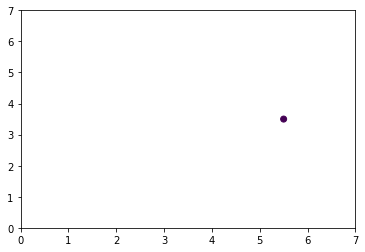

In [11]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.xlim([0,7])
plt.ylim([0,7])

plt.show()

# Classifier

In [12]:
def construct_destructive_classifier(oracle, data_bits, oracle_label="oracle"):
    oracle_gate = oracle.to_gate(label=oracle_label)

    q = QuantumRegister(data_bits + oracle.num_qubits)
    c = ClassicalRegister(data_bits * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[data_bits:])
    qc.append(destructive_swap(data_bits), q[:data_bits] + q[data_bits:data_bits+data_bits])
    for i in range(data_bits * 2 + 1):
        qc.measure(i,i)
    return qc

In [13]:
def classify_destructive(inp, classifier):
    num_qubits = classifier.num_qubits

    data_size = math.ceil(math.log2(len(inp)))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[:data_size])
    qc = qc.compose(classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=10001)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [14]:
def eval_classifier(data, labels, test, oracle, log=False):
    data_bits = math.ceil(math.log2(data.shape[1]))
    classifier = construct_destructive_classifier(oracle, data_bits)

    label_names = [0,1]
    correct = 0
    count = 0
    for index, row in test.iterrows():
        label = row[4]
        results = classify_destructive(row[[0,1]].tolist(), classifier)
        cor = False
        if results[0] > results[1] and label == labels[0]:
            correct += 1
            cor = True
        elif results[0] < results[1] and label == labels[1]:
            correct += 1
            cor = True
        count += 1
        if log:
            print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

    return correct / len(test)
    

# Generator

In [16]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, generator_width, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = generator_width
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)
    
#     print(params)
    
    if params is None:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j*2], j)
            qc.rz(params[i * n_qubits_per_layer + j*2 + 1], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.rxx(params[i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param], j, k)
                next_param += 1
        
        if measurement:
            qc.barrier()
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
    return qc
      
# build_variational_circuit(8, 2, 1, measurement=True).draw()

In [27]:
def generate_params(circuit_depth, circuit_width):

    n_qubits = circuit_width

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi

    return generated_params

In [17]:
eval_classifier(data, labels, test, build_variational_circuit(circuit_depth, circuit_width), log=False)

0.6111111111111112

# Gan

In [18]:
def build_gan_stack(depth, width, orcale, params=None):
    n_data_qubits = width - 1
    
    generator = build_variational_circuit(depth, width, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = oracle.num_qubits + generator.num_qubits + 1
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

oracle, data_bits, counting_bits = construct_oracle(data, labels)
build_gan_stack(circuit_depth, data_bits + 1, oracle).draw()

┌───────┐┌─┐
q2284_0: ──────────────┤0      ├┤M├
         ┌────────────┐│       │└╥┘
q2284_1: ┤0           ├┤1      ├─╫─
         │  generator ││       │ ║ 
q2284_2: ┤1           ├┤2 swap ├─╫─
         └┬─────────┬─┘│       │ ║ 
q2284_3: ─┤0        ├──┤3      ├─╫─
          │         │  │       │ ║ 
q2284_4: ─┤1 oracle ├──┤4      ├─╫─
          │         │  └───────┘ ║ 
q2284_5: ─┤2        ├────────────╫─
          └─────────┘            ║ 
  c74: 1/════════════════════════╩═
                                 0

In [20]:
def build_gan_stack_with_count(depth, width, oracle, params=None):
#     oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
#     width = oracle.num_qubits
    generator = build_variational_circuit(depth, width, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = oracle.num_qubits + generator.num_qubits + 1
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
#     generator_output_qubits = q[1:1 + width]
    oracle_qubits = q[generator.num_qubits + 1:]
#     oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + width]
#     oracle_label_qubits = q[generator.num_qubits + 1 + width - 1:generator.num_qubits + width + 1]

#     oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(oracle.num_qubits)
    swap_test_qubits = swap_ancilla + generator_qubits + oracle_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack_with_count(circuit_depth, circuit_width, construct_oracle(data, labels)[0]).draw()

┌───────┐┌─┐
q2297_0: ──────────────┤0      ├┤M├
         ┌────────────┐│       │└╥┘
q2297_1: ┤0           ├┤1      ├─╫─
         │            ││       │ ║ 
q2297_2: ┤1 generator ├┤2      ├─╫─
         │            ││       │ ║ 
q2297_3: ┤2           ├┤3 swap ├─╫─
         └┬─────────┬─┘│       │ ║ 
q2297_4: ─┤0        ├──┤4      ├─╫─
          │         │  │       │ ║ 
q2297_5: ─┤1 oracle ├──┤5      ├─╫─
          │         │  │       │ ║ 
q2297_6: ─┤2        ├──┤6      ├─╫─
          └─────────┘  └───────┘ ║ 
  c75: 1/════════════════════════╩═
                                 0

In [32]:
def train_gan(gan_builder, data, labels, iterations):
    intermediate_results = []

    n_qubits = circuit_width

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    param_size = circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)
    total_runs = 0
    
    oracle,_,_ = construct_oracle(data, labels)
    init_params = generate_params(circuit_depth, circuit_width)

    
    best_result = -np.Inf
    best_params = init_params
    
    

    def objective_function(params):
        nonlocal total_runs
        nonlocal best_result
        nonlocal best_params
        params.shape = (params.size // param_size, param_size)
        results = []
        tracked_inter_res = False

        total_runs += params.shape[0]
        for param_set in params:
            # construct circuit with given params
            qc = gan_builder(circuit_depth, circuit_width, oracle, param_set)

            backend = Aer.get_backend('qasm_simulator')
            job = execute(backend=backend, experiments=qc, shots=100000)
            counts = job.result().get_counts()

            result = 2 * counts['0'] / sum(counts.values()) - 1
            if not tracked_inter_res:
                print("Intermediate:", result)
                print("total runs: ", total_runs)
                intermediate_results.append(-result)
                tracked_inter_res = True
                
            if result < best_result:
                best_result = result
                best_params = params
            
            results.append(-result)

        return results


    print("Initial parameters:", init_params)
    # objective_function(params)

    # optimizer = COBYLA(maxiter=100)
    optimizer = AQGD(maxiter=iterations)

    ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

    print("Supposed optimal parameters:", ret)
    plt.plot(intermediate_results)
    plt.show()
    return best_result, best_params


Initial parameters: [1.77777362 1.20822983 2.96099403 0.35224223 2.446795   1.45621826
 1.4128937  1.57071106 1.16038866 0.68174144 1.32670708 2.28523294
 2.99220815 1.22312407 3.1358539  1.21521277 0.66675794 0.86453518
 1.55032737 0.44969678 2.48951501 1.61613414 1.17306179 0.45699197
 2.08648776 1.70589266 1.04384471]


/home/leo/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


Intermediate: 0.008280000000000065
total runs:  55
Intermediate: 0.023360000000000047
total runs:  110
Intermediate: 0.12647999999999993
total runs:  165
Intermediate: 0.41574
total runs:  220
Intermediate: 0.6676200000000001
total runs:  275
Intermediate: 0.8288599999999999
total runs:  330
Intermediate: 0.9158200000000001
total runs:  385
Intermediate: 0.9544600000000001
total runs:  440
Intermediate: 0.97024
total runs:  495
Intermediate: 0.97844
total runs:  550
Intermediate: 0.9826999999999999
total runs:  605
Intermediate: 0.9849000000000001
total runs:  660
Intermediate: 0.9874400000000001
total runs:  715
Intermediate: 0.9902200000000001
total runs:  770
Intermediate: 0.9904599999999999
total runs:  825
Intermediate: 0.9917800000000001
total runs:  880
Intermediate: 0.99312
total runs:  935
Intermediate: 0.994
total runs:  990
Intermediate: 0.9946200000000001
total runs:  1045
Intermediate: 0.99474
total runs:  1100
Intermediate: 0.99468
total runs:  1155
Intermediate: 0.99566


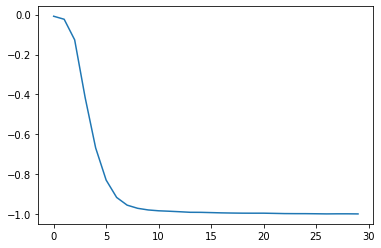

# evaluation

In [23]:
#accuracy with real data classifier
eval_classifier(data, labels, test, construct_oracle(data, labels)[0], log=True)

features:(5.0, 3.3), label:0.0, result:0:0.9996008780682499, 1:0.9791583166332665, correct, accuracy:1.0
features:(5.0, 3.6), label:0.0, result:0:0.9995964487489912, 1:0.9766105054509415, correct, accuracy:1.0
features:(5.1, 3.8), label:0.0, result:0:0.995164215192424, 1:0.9690353314807463, correct, accuracy:1.0
features:(7.2, 3.0), label:1.0, result:0:0.9675285628382442, 1:0.9968076616121309, correct, accuracy:1.0
features:(5.0, 3.5), label:0.0, result:0:0.99839518555667, 1:0.9716905901116428, correct, accuracy:1.0
features:(5.4, 3.7), label:0.0, result:0:0.999603410668253, 1:0.9786204114562322, correct, accuracy:1.0
features:(6.3, 2.9), label:1.0, result:0:0.9785901838012523, 1:1.0, correct, accuracy:1.0
features:(4.4, 3.2), label:0.0, result:0:0.9952076677316295, 1:0.9647506509112758, correct, accuracy:1.0
features:(6.4, 3.2), label:1.0, result:0:0.9905269390171698, 1:0.999189298743413, correct, accuracy:1.0
features:(4.5, 2.3), label:0.0, result:0:0.9908784453698196, 1:0.9991932230

0.9722222222222222

Initial parameters: [2.14308363 0.57144376 0.29819602 3.06571545 2.52433055 2.98758625
 2.93771863 2.13478725 2.91870504 2.23904388 0.47768037 0.90338339
 2.75190833 0.0085128  2.71008185 0.97833272 2.3231811  0.08751679
 1.63198025 2.82056789 2.21358594 1.72177991 0.33448913 0.3739359
 2.00960307 1.4231355  1.76669504]
Intermediate: 0.0480799999999999
total runs:  55
Intermediate: 0.1014600000000001
total runs:  110
Intermediate: 0.25102
total runs:  165
Intermediate: 0.4428000000000001
total runs:  220
Intermediate: 0.6287
total runs:  275
Intermediate: 0.8109599999999999
total runs:  330
Intermediate: 0.90682
total runs:  385
Intermediate: 0.9432400000000001
total runs:  440
Intermediate: 0.96302
total runs:  495
Intermediate: 0.97648
total runs:  550
Intermediate: 0.9834
total runs:  605
Intermediate: 0.98722
total runs:  660
Intermediate: 0.9901
total runs:  715
Intermediate: 0.99224
total runs:  770
Intermediate: 0.9927600000000001
total runs:  825
Intermediate: 0.993640000000000

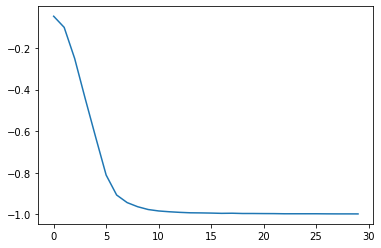

In [31]:
similarity, best_params = train_gan(build_gan_stack_with_count, data, labels, 20)

In [34]:
generator = build_variational_circuit(build_variational_circuit(circuit_depth, circuit_width, params = best_params))

TypeError: build_variational_circuit() missing 1 required positional argument: 'generator_width'

In [ ]:
eval_classifier(data, labels, test, generator, log=True)